# Implementation of Dynamic Ensemble Selection
This script contain the learning and classification process of Multisource Remote Sensing data for Land Cover Land Use Mapping. The data is prepared in Earth Engine, and downloaded to be process in desktop machine. The training data is created using visual interpretation, assisted with Indonesia Topographical Map
<br>
This script is organized as follows:
1. Library Import and Pixel Extraction
2. Hyperparameter Optimization
3. Model Evaluation
4. Classification
<br>
1. K-Nearest Oracles (KNORA) Elimminate
2. Meta Learning for Dynamic Ensemble Selection (METADES)

**1. Importing the Library**

In [1]:
#Library for Raster data processing
import rasterio
#Library for numerical and spatial data processing
import numpy as np
from numpy import mean
from numpy import std
import geopandas as gpd
import pandas as pd
#library for plotting 
import matplotlib.pyplot as plt
#Library for saving fitted model
import joblib
#Library for Dynamic Ensemble Selection
import deslib
#import DES techniques from DESlib
from deslib.des.des_p import DESP
from deslib.des.knora_u import KNORAU
from deslib.des.knora_e import KNORAE
from deslib.des.meta_des import METADES
#Accuracy Assessment Metrics
from sklearn.metrics import log_loss, accuracy_score, f1_score
from imblearn.metrics import geometric_mean_score
from sklearn.model_selection import cross_val_score, KFold, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.utils import shuffle
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split, GridSearchCV, RandomizedSearchCV

**1.1 Importing the Raster and Training Data**

In [2]:
#importing the raster data
raster_file = 'C:\Master of Remote Sensing\Python Code\EL_Research\Imagery\Multisource_Combine_clip.tif'
dataset = rasterio.open(raster_file)  
# Bands Names
desc = dataset.descriptions
print('Raster description: {desc}\n'.format(desc=desc)) 
#inspecting the raste file. The format is bands,row, column
L9_MS = dataset.read()
#tranpose the data into the form of row, column, bands
L9_MS = L9_MS.transpose(1, 2, 0)
L9_MS.shape
#adding the training data
sample = gpd.read_file('C:\Master of Remote Sensing\Python Code\Basic_ML_research\TD_New\TrainingSamples_rev21.shp')


Raster description: ('B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B10', 'GNDVI', 'NDMI', 'EVI', 'MNDWI', 'MSAVI', 'BLFEI', 'AWEI_sh', 'FlowA', 'TPILF', 'TWI', 'DEM', 'slope', 'aspect')



**1.2 Pixel Extraction Function**

In [3]:
from rasterio.features import shapes
from rasterio.mask import mask
def extract_pixels_from_shapefile(shapefile, raster):
    training_samples = []
    for index, row in shapefile.iterrows():
        geometry = [row['geometry']]
        id_class = row['LUCID']

        # Mask raster untuk mendapatkan pixel values yang terdapat dalam geometry shapefile
        out_image, out_transform = mask(raster, geometry, crop=True)

        # out_image shape: (bands, height, width) -- Reshape menjadi (pixels, bands)
        out_image = out_image.reshape(raster.count, -1).T  # Sekarang (pixels, bands)

        # menghapus Nan Pixels (Jika ada piksel dalam suatu band bernilai NaN)
        valid_pixels = out_image[~np.isnan(out_image).any(axis=1)]

        # Menambahkan valid pixel sebagai feature bersamaan dengan kelas labelnya
        for pixel in valid_pixels:
            training_samples.append((pixel, id_class))

    # Converts the tuple list kedalam numpy array
    features = np.array([sample[0] for sample in training_samples])  # Extract pixel values (features)
    labels = np.array([sample[1] for sample in training_samples])    # Extract class labels
    return features, labels

In [4]:
# Menggunakan funtion extract pixel values yang sudah dibuat untuk mendapatkan fatures dan label:
features, labels = extract_pixels_from_shapefile(sample, dataset)

# Cek shape dari features dan labels
print(features.shape)
print(labels.shape)
# Membuat mask untuk cek Nan values dari feature dan label
nan_mask = np.isnan(features).any(axis=1) | np.isnan(labels)

# Apabila ada Nan value maka akan dihapuskan
features = features[~nan_mask]
labels = labels[~nan_mask]

# Menghitung final total sampel masing-masing kelas
sample_new = pd.DataFrame({'class': labels})
print(sample_new['class'].value_counts())

(21668, 21)
(21668,)
class
4.0     3476
19.0    2427
13.0    1928
10.0    1925
14.0    1809
17.0    1614
3.0     1269
8.0     1206
15.0    1136
0.0     1111
16.0    1099
18.0     574
7.0      510
2.0      445
6.0      261
11.0     229
1.0      152
5.0      151
9.0      134
12.0     118
20.0      94
Name: count, dtype: int64


**1.3 Training and testing split**
Two stage of training data spliting:
1. First stage is for the pool classifiers training data (x_train, y_train)
2. Second stage, splitting the already splitted training data (x_train, y_train) into training data which will be used for DES model prediction (x_dsel, y_dsel)

In [13]:
from sklearn.model_selection import train_test_split
# Split data: 80% for training and 20% for testing
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, stratify=labels, random_state=42)
print('Testing data ', x_test.shape, y_test.shape)
# Split the data into training and DSEL for DS techniques
x_train, x_dsel, y_train, y_dsel = train_test_split(x_train, y_train, stratify=y_train, test_size=0.3, random_state=42)
print("Training data for DES", x_dsel.shape, y_dsel.shape)
print('Training data for the pool classifiers', x_train.shape, y_train.shape)

#calculate the class distribution of pixels
un_class_train, class_count_train = np.unique(y_train, return_counts=True)
un_class_dsel, class_count_dsel = np.unique(y_dsel, return_counts=True)
un_class_test, class_count_test = np.unique(y_test, return_counts=True )
# Correct the union of unique classes for all datasets
all_classes = np.unique(np.concatenate([un_class_train, un_class_dsel, un_class_test]))

# Create the DataFrame for class pixel counts
class_pixel_count = pd.DataFrame({
    'Class': all_classes,
    'Pool Training Data': [
        class_count_train[un_class_train.tolist().index(cls)] if cls in un_class_train else 0
        for cls in all_classes
    ],
    'DES Training Data': [
        class_count_dsel[un_class_dsel.tolist().index(cls)] if cls in un_class_dsel else 0
        for cls in all_classes
    ],
    'Test Pixel': [
        class_count_test[un_class_test.tolist().index(cls)] if cls in un_class_test else 0
        for cls in all_classes
    ]
})

# Display the resulting DataFrame
print(class_pixel_count)
#class_pixel_count.to_csv('C:/Master of Remote Sensing/Python Code/HyperparameterTune_L9/train_test_knora.csv')

Testing data  (4334, 21) (4334,)
Training data for DES (5201, 21) (5201,)
Training data for the pool classifiers (12133, 21) (12133,)
    Class  Pool Training Data  DES Training Data  Test Pixel
0     0.0                 622                267         222
1     1.0                  85                 37          30
2     2.0                 249                107          89
3     3.0                 710                305         254
4     4.0                1947                834         695
5     5.0                  85                 36          30
6     6.0                 146                 63          52
7     7.0                 286                122         102
8     8.0                 676                289         241
9     9.0                  75                 32          27
10   10.0                1078                462         385
11   11.0                 128                 55          46
12   12.0                  66                 28          24
13   13.0   

**2. Parameter Space Definition and Hyperparameter Tuning/Optimization for Pool Classifiers**

In [7]:
#MLP Parameter Grid
mlp_param_grid = {
    'hidden_layer_sizes': [(128, 64), (256, 128), (512, 256, 128)],
    'activation': ['tanh', 'relu'],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [500, 1000, 1500, 2000],
    'learning_rate_init': [0.0001, 0.0005, 0.001, 0.01]
}
mlp_model = MLPClassifier(solver='adam', early_stopping = True, random_state=42)
ERT_param = {
    'n_estimators' : [300, 500, 700, 900, 1100],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 7, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}
init_ET = ExtraTreesClassifier(random_state=42)
# Define the parameter grid for randomized search
xgb_param_grid = {
    'n_estimators': [500, 700, 900, 1100],
    'max_depth': [3, 6, 15, 20],
    'min_child_weight': [1, 3, 9, 13],
    'learning_rate': [0.001, 0.01, 0.1, 0.2],
    'subsample': [0.1, 0.5, 1.0],
    'colsample_bytree': [0.1, 0.5, 1.0]    
}
xgb_model = XGBClassifier(objective='multi:softprob', num_class = 21, eval_metric = 'mlogloss', random_state=42)
hgbm_param = {
    'learning_rate': [0.0001, 0.01, 0.1, 0.05, 0.2],
    'max_iter': [500, 700, 1000, 1500],  
    'max_depth': [None, 3, 9, 12, 15, 20],  
    'min_samples_leaf': [5, 10, 15, 20], 
    'max_bins': [32, 64, 255]
}
hgbm = HistGradientBoostingClassifier(random_state=42)
#List for storing the result

# Initialize a list to store results
results = []
import time

In [19]:
# Randomized Search with Cross Validation for XGB
start_xgb = time.time()
# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=xgb_param_grid,
    n_iter=20,  # Number of parameter settings to sample
    scoring='accuracy',  # Evaluation metric
    cv=9,  # 3-fold cross-validation
    verbose=2,  # Print progress
    random_state=42,
    n_jobs=-1  # Use all available cores
)
random_search.fit(x_train, y_train)
end_xgb = time.time()
time_xgb = end_xgb - start_xgb
print('GCV best score for ET', random_search.best_score_)
print('GCV best parameter for ET', random_search.best_params_)

Fitting 9 folds for each of 20 candidates, totalling 180 fits
GCV best score for ET 0.6999094101283216
GCV best parameter for ET {'subsample': 1.0, 'n_estimators': 1100, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.2, 'colsample_bytree': 1.0}


In [20]:
# Start the timer
start_time = time.time()
mlp_gcv = RandomizedSearchCV(mlp_model, mlp_param_grid, n_iter=20, cv=9, scoring='accuracy', n_jobs=-1, verbose=2)
mlp_gcv.fit(x_train, y_train)
best_mlp = mlp_gcv.best_estimator_
# End the timer
end_time = time.time()
mlp_time = end_time - start_time
print('Best CV Accuracy MLP', mlp_gcv.best_score_)
print('Best parameters for MLP', mlp_gcv.best_params_)
print('Time', mlp_time)
#tuning time92.15530729293823

Fitting 9 folds for each of 20 candidates, totalling 180 fits
Best CV Accuracy MLP 0.5419929209630561
Best parameters for MLP {'max_iter': 1000, 'learning_rate_init': 0.001, 'learning_rate': 'constant', 'hidden_layer_sizes': (256, 128), 'activation': 'tanh'}
Time 356.1402792930603


In [21]:
start_time = time.time()
hgb = RandomizedSearchCV(hgbm, hgbm_param, n_iter=20, cv=9, scoring='accuracy', n_jobs=-1)
hgb.fit(x_train, y_train)
best_hgb = hgb.best_estimator_
end_time = time.time()
hgb_time = end_time - start_time
print('Best param', hgb.best_params_)
print('Best CV accuracy', hgb.best_score_)
print('hgb time', hgb_time)
#250.40935063362122

Best param {'min_samples_leaf': 20, 'max_iter': 1500, 'max_depth': 15, 'max_bins': 64, 'learning_rate': 0.05}
Best CV accuracy 0.6997442513375846
hgb time 721.0083634853363


In [22]:
start_ert = time.time()
et_rcv = RandomizedSearchCV(
    estimator = init_ET, 
    param_distributions= ERT_param, 
    n_iter=20, 
    cv=9, 
    verbose=2, 
    n_jobs=-1, 
    scoring='accuracy',
    random_state=42)
et_rcv.fit(x_train, y_train)
end_ert = time.time()
time_ert = end_ert - start_ert
print('GCV best score for ET', et_rcv.best_score_)
print('GCV best parameter for ET', et_rcv.best_params_)

Fitting 9 folds for each of 20 candidates, totalling 180 fits
GCV best score for ET 0.7011456875286111
GCV best parameter for ET {'n_estimators': 300, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 20, 'bootstrap': False}


In [23]:
best_xgb = random_search.best_estimator_
best_ert = et_rcv.best_estimator_
joblib.dump(best_xgb, 'C:\Master of Remote Sensing\Python Code\EL_Research\Model Learnining\Pool_XGB_Best.pkl',  compress=('zlib', 3))
joblib.dump(best_mlp, 'C:\Master of Remote Sensing\Python Code\EL_Research\Model Learnining\Pool_MLP_Best.pkl',  compress=('zlib', 3))
joblib.dump(best_hgb, 'C:\Master of Remote Sensing\Python Code\EL_Research\Model Learnining\Pool_HGB_Best.pkl',  compress=('zlib', 3))
joblib.dump(best_ert, 'C:\Master of Remote Sensing\Python Code\EL_Research\Model Learnining\Pool_ERT_Best.pkl',  compress=('zlib', 3))

['C:\\Master of Remote Sensing\\Python Code\\EL_Research\\Model Learnining\\Pool_ERT_Best.pkl']

In [8]:
best_xgb = joblib.load('C:\Master of Remote Sensing\Python Code\EL_Research\Model Learnining\Pool_XGB_Best.pkl')
best_mlp = joblib.load('C:\Master of Remote Sensing\Python Code\EL_Research\Model Learnining\Pool_MLP_Best.pkl')
best_hgb = joblib.load('C:\Master of Remote Sensing\Python Code\EL_Research\Model Learnining\Pool_HGB_Best.pkl')
best_ert = joblib.load('C:\Master of Remote Sensing\Python Code\EL_Research\Model Learnining\Pool_ERT_Best.pkl')

**Manual cross validation for DES Classiifers**

>2 0.639 (0.017)
>3 0.635 (0.017)
>4 0.628 (0.020)
>5 0.628 (0.017)
>6 0.622 (0.018)
>7 0.620 (0.017)
>8 0.623 (0.017)
>9 0.619 (0.016)
>10 0.616 (0.016)
>11 0.616 (0.017)
>12 0.621 (0.019)
>13 0.614 (0.018)
>14 0.615 (0.021)
>15 0.618 (0.020)
>16 0.616 (0.018)
>17 0.614 (0.020)
>18 0.614 (0.016)
>19 0.619 (0.018)
>20 0.616 (0.017)
>21 0.612 (0.018)


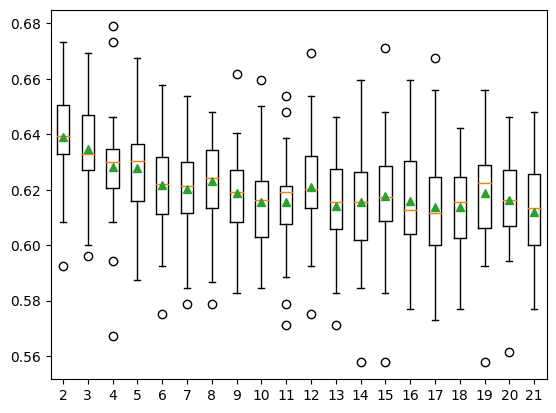

In [9]:
#Function for Evaluating the number of k-neighbor in KNORAU
def get_models():
	models = dict()
	for n in range(2,22):
		models[str(n)] = KNORAE(k=n, DFP=True, voting='soft')
	return models
 
# evaluate a give model using cross-validation
def evaluate_model(model):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, x_dsel, y_dsel, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

**3. Used the tuned pool classifiers for DES classifiers**

In [16]:
#Provide the list for the pool classifiers
pool_clf = [best_xgb,  best_ert, best_hgb, best_mlp]
des_result = []
#K-Nearest Oracles-Eliminate
knorae = KNORAE(pool_classifiers=pool_clf, k=15, DFP=True, voting='soft', DSEL_perc = 0.1)
knorae.fit(x_dsel, y_dsel)
y_pred_e = knorae.predict(x_test)
y_prob_e = knorae.predict_proba(x_test)
des_result.append({
    'Classifier': 'KNORA-E',
    'Accuracy': accuracy_score(y_test, y_pred_e),
    'F1-Score': f1_score(y_test, y_pred_e, average='weighted'),
    })
#METADES
metades = METADES(pool_classifiers=pool_clf, k=7, DFP=True, voting='soft', Hc=0.5, DSEL_perc = 0.1)
metades.fit(x_dsel, y_dsel)
y_pred_des = metades.predict(x_test)
y_prob_des = metades.predict_proba(x_test)
des_result.append({
    'Classifier': 'METADES',
    'Accuracy': accuracy_score(y_test, y_pred_des),
    'F1-Score': f1_score(y_test, y_pred_des, average='weighted'),
    })
des_result_df = pd.DataFrame(des_result)
print(des_result_df)

  Classifier  Accuracy  F1-Score
0    KNORA-E  0.712044  0.743347
1    METADES  0.714352  0.745848


**4. Model Evaluation**

Since the data is imbalance, several metrics is used to assess the model:
1. Overall Accuracy
2. Cross Entropy Loss (CE)
3. F1 Score
4. Geometric Mean (Gmean)

For CE Loss, F1, and Gmean, calculation is conducted while utilizing the class weight of each class

In [17]:
from sklearn.utils.class_weight import compute_class_weight
# Classifiers and corresponding transformed test data
classifiers = {
    'KNORA-E': {'model': knorae, 'x_train': x_dsel, 'x_test': x_test},
    'METADES': {'model': metades, 'x_train': x_dsel, 'x_test': x_test},
}

# Store results
individual_accuracies = []

# Calculate class weights and evaluate classifiers
for name, clf_data in classifiers.items():
    clf = clf_data['model']
    x_train = clf_data['x_train']
    x_test = clf_data['x_test']

    # Calculate class weights based on RFECV-reduced training data
    unique_classes = np.unique(y_dsel)  # Assuming y_train is the same for all classifiers
    weights = compute_class_weight(
        class_weight='balanced',
        classes=unique_classes,
        y=y_dsel
    )
    class_weight_dict = dict(zip(unique_classes, weights))

    # Predict using the current classifier
    y_pred = clf.predict(x_test)
    y_pred_proba = clf.predict_proba(x_test)

    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted', sample_weight=[class_weight_dict[cls] for cls in y_test])
    w_logloss = log_loss(y_test, y_pred_proba, sample_weight=[class_weight_dict[cls] for cls in y_test])
    gmean = geometric_mean_score(y_test, y_pred, average='weighted', sample_weight=[class_weight_dict[cls] for cls in y_test])

    # Append results
    individual_accuracies.append((name, acc, f1, w_logloss, gmean))
    print(f'Accuracy of {name}: {acc:.4f}')
    print(f'F1 Score of {name}: {f1:.4f}')
    print(f'Log loss of {name}: {w_logloss:.4f}')
    print(f'Geometric Mean of {name}: {gmean:.4f}')

# Identify the worst-performing classifier
worst_classifier = min(individual_accuracies, key=lambda x: x[1])
print(f'\nWorst-performing classifier: {worst_classifier[0]} with accuracy: {worst_classifier[1]:.4f}')
print(f'F1 Score of worst-performing classifier: {worst_classifier[2]:.4f}')

# Convert results to DataFrame for easier visualization
columns = ['Classifier', 'Overall Accuracy', 'F1 Score', 'Log Loss', 'Geometric Mean']
result_df = pd.DataFrame(individual_accuracies, columns=columns)
print(result_df)
# Save the DataFrame
#result_df.to_csv('C:/Master of Remote Sensing/Python Code/HyperparameterTune_L9/DES_accuracy.csv', index=True)


c:\Users\62853\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2956: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Accuracy of KNORA-E: 0.7120
F1 Score of KNORA-E: 0.7412
Log loss of KNORA-E: 1.2773
Geometric Mean of KNORA-E: 0.8089
Accuracy of METADES: 0.7144
F1 Score of METADES: 0.7422
Log loss of METADES: 1.2795
Geometric Mean of METADES: 0.8099

Worst-performing classifier: KNORA-E with accuracy: 0.7120
F1 Score of worst-performing classifier: 0.7412
  Classifier  Overall Accuracy  F1 Score  Log Loss  Geometric Mean
0    KNORA-E          0.712044  0.741187  1.277324        0.808882
1    METADES          0.714352  0.742201  1.279524        0.809898


c:\Users\62853\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2956: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


**6. Applied the DES classifiers into the whole dataset**

In [20]:
import rasterio
from rasterio.transform import from_origin
#The classification funtion
def classify_raster(raster, model):
    # Reshape raster data into (pixels, bands)
    raster_data = raster.read().reshape((raster.count, -1)).T  # (pixels, bands)
    
    # Handle any invalid or missing data in the raster (e.g., NaN values)
    mask = np.isnan(raster_data).any(axis=1)  # Identify invalid pixels
    classified = np.full(raster_data.shape[0], -1, dtype=int)  # Initialize with a NoData value
    
    # Perform classification on valid pixels only
    classified[~mask] = model.predict(raster_data[~mask])
    
    # Reshape back to raster dimensions
    return classified.reshape((raster.height, raster.width))
def export_classified_map(classified_map, reference_raster, output_path, nodata_value=-1):
    # Copy metadata from reference raster
    meta = reference_raster.meta.copy()
    
    # Update metadata for classification output
    meta.update({
        "driver": "GTiff",
        "dtype": "int32",
        "count": 1,  # Single band
        "nodata": nodata_value,  # Define NoData value
        "compress": "lzw"
    })
    
    # Export the classified raster
    with rasterio.open(output_path, 'w', **meta) as dst:
        dst.write(classified_map.astype('int32'), 1)

In [21]:
# Perform classification
classified_map = classify_raster(dataset, knorae )
# Classified the raster
output_tif_path = 'C:/Master of Remote Sensing/Python Code/EL_Research/NewOutput/New_KNORA-E.tif'
export_classified_map(classified_map, dataset, output_tif_path)

In [22]:
classified_metades = classify_raster(dataset, metades)
output = 'C:/Master of Remote Sensing/Python Code/EL_Research/NewOutput/New_METADES.tif'
export_classified_map(classified_metades, dataset, output)

**Visualization of the Land Cover Land Use Map**

c:\Users\62853\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\cm.py:496: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


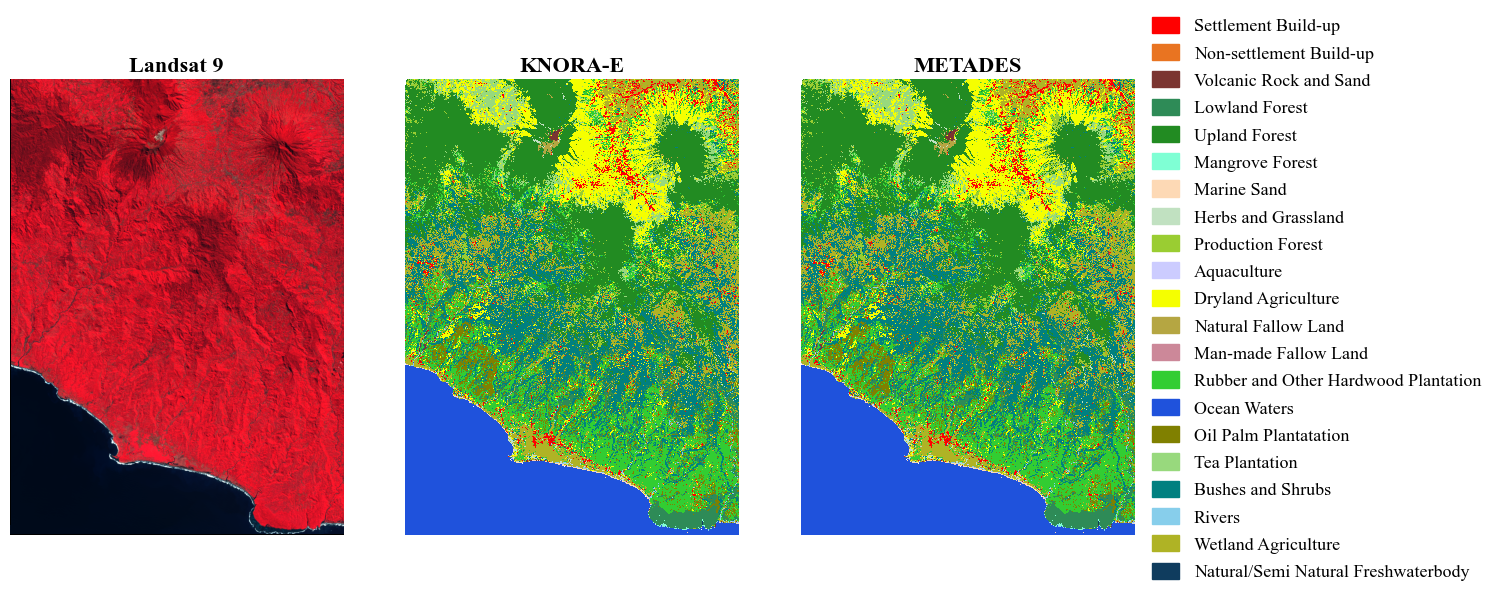

In [25]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, BoundaryNorm
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
from matplotlib.offsetbox import AnchoredText
# 1. Define legend and colors for classes
legend_21 = ['Settlement Build-up', 'Non-settlement Build-up', 'Volcanic Rock and Sand', 'Lowland Forest', 
             'Upland Forest', 'Mangrove Forest', 'Marine Sand', 'Herbs and Grassland', 'Production Forest', 
             'Aquaculture', 'Dryland Agriculture', 'Natural Fallow Land', 'Man-made Fallow Land', 'Rubber and Other Hardwood Plantation',
             'Ocean Waters','Oil Palm Plantatation','Tea Plantation', 'Bushes and Shrubs', 'Rivers', 'Wetland Agriculture',
             'Natural/Semi Natural Freshwaterbody']

legend_colors = ['#FF0000', '#e97421', '#7b3531', '#2e8b57', '#228b22', '#7fffd4', '#fdd9b5', 
                 '#c1e1c1', '#9acd32', '#ccccff', '#f5ff00', '#b5a642', '#cc8899', '#32cd32', 
                  '#1f52dc', '#808000', '#98d97d','#008080', '#87ceeb', '#afb325', '#0f3c5e']
#2. define the Original Raster data, and LULC data
rasters = {
    'Landsat 9': r'C:\Master of Remote Sensing\Python Code\Github_Repo_TassCap_Project\Data Source\Landsat9_Final_Addtwi.tif',
    'KNORA-E':   r"C:/Master of Remote Sensing/Python Code/EL_Research/NewOutput/New_KNORA-E.tif",
    'METADES': r"C:/Master of Remote Sensing/Python Code/EL_Research/NewOutput/New_METADES.tif"
}

cmap  = ListedColormap(legend_colors, name="lulc21") # Build a discrete Colormap from the predefined hex color code
bounds = np.arange(len(legend_colors)+1) - 0.5       #Bound the pixel values, with no gradient or shades
norm   = BoundaryNorm(bounds, cmap.N) #Asigning one color one id

# 3.  Creating Layout Plot
mpl.rcParams.update({
    'font.family'     : 'Times New Roman',
})
n_maps = len(rasters) #Images that will be plot
n_rows = 1  #number of row 
n_cols = int(np.ceil(n_maps / n_rows)) # minimum cols to fit everything

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 5*n_rows), #Canvas size in inches
                         sharex=True, sharey=True)
axes = axes.ravel() #Flatten the 2D Numpy Array for easier looping
# 4.  Create a loop through each raster
for ax, (title, path) in zip(axes, rasters.items()):
    with rasterio.open(path) as src:
        if src.count > 1 and title.startswith("Landsat"):   # multiband FCC
            # --- READ BANDS 5,4,3 (1‑based) ---
            nir  = src.read(5).astype("float32")
            red  = src.read(4).astype("float32")
            green= src.read(3).astype("float32")
            rgb  = np.stack([nir, red, green], axis=-1)

            # --- SIMPLE PERCENTILE STRETCH (2‑98%) ---
            p2, p98 = np.percentile(rgb[~np.isnan(rgb)], (2, 98))
            rgb = np.clip((rgb - p2) / (p98 - p2), 0, 1)

            ax.imshow(rgb)
        else:                                              # categorical LULC
            data = src.read(1)
            nodata_vals = {src.nodata, -1}
            nodata_vals = {v for v in nodata_vals if v is not None}
            mask = np.isin(data, list(nodata_vals))
            data = np.where(mask, np.nan, data)
            ax.imshow(data, cmap=cmap, norm=norm, interpolation="nearest")

    ax.set_title(title,fontsize=16, fontweight= 'bold')
    ax.axis('off')

# hide any empty subplot (there will be one in a 2×3 grid)
for extra_ax in axes[n_maps:]:
    extra_ax.axis('off')

# 5.  Adding Legend for LULC Map
handles = [mpatches.Patch(color=c, label=lab)
           for lab, c in zip(legend_21, legend_colors)]

fig.legend(
    handles=handles,
    loc='center left', bbox_to_anchor=(0.97, 0.5),
    ncol=1,
    fontsize=13,
    frameon=False,
    handlelength=1.5,
    handleheight=1
)
plt.tight_layout(pad=1)
plt.show()